In [1]:
# Only display tensorflow errors
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, LSTM
from keras.losses import MeanSquaredError as MSE, MeanAbsoluteError as MAE, Huber
from keras.metrics import MeanAbsoluteError, MeanSquaredError
from tcn import TCN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


2025-03-26 07:45:11.306009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742967911.316457 4177359 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742967911.319630 4177359 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742967911.328873 4177359 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742967911.328880 4177359 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742967911.328882 4177359 computation_placer.cc:177] computation placer alr

In [2]:
df = pd.read_csv('data/comp-merged.csv')
df = df[['value_acc', 'value_met']]
scaler = MinMaxScaler()
df['value_met'] = scaler.fit_transform(df['value_met'].values.reshape(-1, 1))
df['value_acc'] = scaler.transform(df['value_acc'].values.reshape(-1, 1))

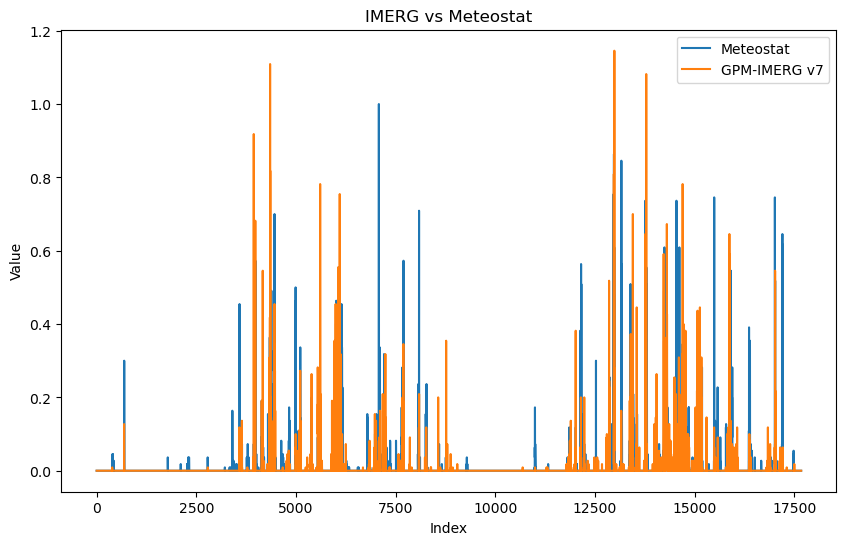

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(df['value_met'], label='Meteostat')
plt.plot(df['value_acc'], label='GPM-IMERG v7')
plt.title('IMERG vs Meteostat')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [4]:
batch_size = 1024
epochs = 1000
window_size = 32

In [5]:
def windowed_dataset(data, window_size, batch_size, shift=1, shuffle=True):
    """
    Create a windowed dataset from the input data.

    Parameters:
    data (np.array): The input data array.
    window_size (int): The size of each window.
    batch_size (int): The size of each batch.

    Returns:
    tf.data.Dataset: The windowed dataset.
    """
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size, shift=shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.map(lambda window: (tf.expand_dims(window[:, 0], axis=-1), tf.expand_dims(window[:, 1], axis=-1)))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
def windowed_dataset_single(data, window_size, batch_size):
    """
    Create a windowed dataset from the input data.

    Parameters:
    data (np.array): The input data array.
    window_size (int): The size of each window.
    batch_size (int): The size of each batch.

    Returns:
    tf.data.Dataset: The windowed dataset.
    """
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size, shift=window_size, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.map(lambda window: tf.expand_dims(window, axis=-1))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
# Split the dataframe into train and test sets
train, test = train_test_split(df, test_size=0.05, shuffle=False)

train_set = windowed_dataset(train, window_size, batch_size, shift=1, shuffle=True)
test_set = windowed_dataset(test, window_size, batch_size, shift=window_size, shuffle=False)

I0000 00:00:1742967917.447679 4177359 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22238 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:08:00.0, compute capability: 8.6


(1024, 32, 1)
(564672,)
(17677,)


/tmp/ipykernel_4177359/4153096080.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


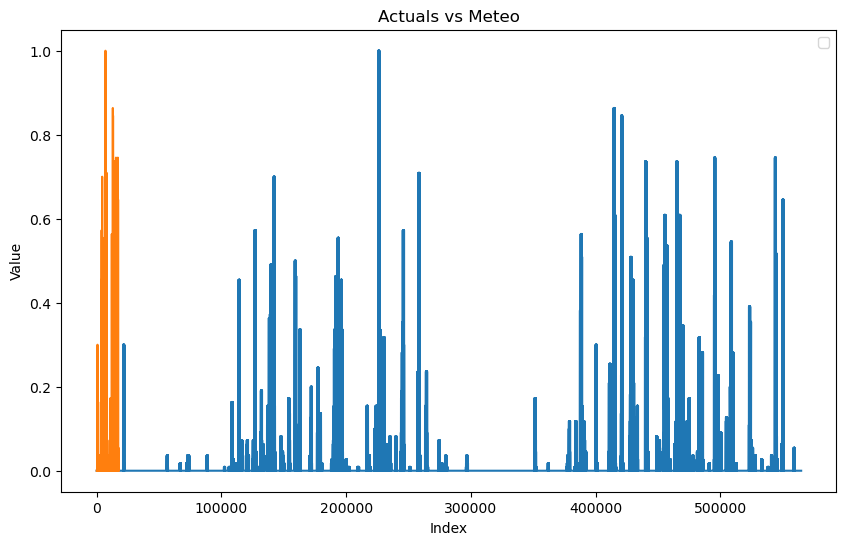

In [8]:
data = windowed_dataset(df, window_size, batch_size, shuffle=False)
actuals = [y for x, y in data]
print(actuals[0].shape)
actuals = np.concatenate(actuals, axis=0).flatten()

print(actuals.shape)
print(df['value_met'].shape)

plt.figure(figsize=(10, 6))
plt.plot(actuals)
plt.plot(df['value_met'])
plt.title('Actuals vs Meteo')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [9]:
class RootMeanSqauredError(MeanSquaredError):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(y_true, y_pred, sample_weight)

    def result(self):
        return tf.sqrt(super().result())

In [13]:
def build_model():
    """
    Build a CONV-LSTM model for error correction.
    
    Returns:
    keras.Model: The compiled model
    """
    # Input layer
    inputs = Input(shape=(window_size, 1))
    
    # # Encoder: progressively extract features with additional regularization
    x = TCN(
        nb_filters=256,
        return_sequences=True,
        dilations=[1, 2, 4, 8],
        use_layer_norm=True,
        use_skip_connections=True,
        dropout_rate=0.15
    )(inputs)
    x = BatchNormalization()(x)
    
    # Bottleneck layer with stronger regularization
    bottleneck = Dense(
        64, 
        activation=None,
        kernel_regularizer=keras.regularizers.l2(1e-4)
    )(x)
    bottleneck = Dropout(0.15)(bottleneck)
    
    # Decoder with additional regularization
    x = TCN(
        nb_filters=256,
        return_sequences=True,
        dilations=[1, 2, 4, 8],
        use_layer_norm=True,
        dropout_rate=0.15
    )(x)
    x = BatchNormalization()(x)
    # x = Dense(
    #     16, 
    #     activation='relu',
    #     kernel_regularizer=keras.regularizers.l2(1e-4)
    # )(x)
    # x = Dense(
    #     8,
    #     activation='relu',
    #     kernel_regularizer=keras.regularizers.l2(1e-4)
    # )(x)
    # Output layer with L2 regularization
    # x = LSTM(
    #     units=32,
    #     return_sequences=True,
    #     kernel_regularizer=keras.regularizers.l2(1e-4),
    #     recurrent_regularizer=keras.regularizers.l2(1.2e-4)
    # )(inputs)
    # x = Dense(
    #     16,
    #     activation=None,
    #     kernel_regularizer=keras.regularizers.l2(1e-4)
    # )(x)
    # x = LSTM(
    #     units=32, 
    #     return_sequences=True,
    #     kernel_regularizer=keras.regularizers.l2(1e-4),
    #     recurrent_regularizer=keras.regularizers.l2(1.2e-4)
    # )(x)
    outputs = Dense(
        1
    )(x)
    
    # Modified learning rate schedule with lower initial rate
    lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,  # Lower initial learning rate
        decay_steps=1000,            # More frequent decay
        decay_rate=0.9              # More aggressive decay
    )

    # Create and compile model with Huber loss
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_scheduler),  # Adam instead of Nadam
        loss=MSE(),  # Huber loss is more robust than MAE
        metrics=[
            MeanSquaredError(name='mse'),
            MeanAbsoluteError(name='mae'),
            RootMeanSqauredError(name='rmse')
        ]
    )
    
    return model

In [14]:
model = build_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn_2 (TCN)                     │ (None, 32, 256)        │       924,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn_3 (TCN)                     │ (None, 32, 256)        │     1,054,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32, 1)          │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,981,697 (7.56 MB)

 Trainable params: 1,980,673 (7.56 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [15]:
history = model.fit(
  train_set,
  epochs=epochs,
  validation_data=test_set,
  verbose=1,
#   callbacks=[keras.callbacks.EarlyStopping(patience=10, monitor='val_rmse', min_delta=1e-6)]
)

Epoch 1/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 549ms/step - loss: 2.3066 - mae: 1.0840 - mse: 2.3066 - rmse: 1.5054 - val_loss: 3.0762 - val_mae: 1.6911 - val_mse: 3.0762 - val_rmse: 1.7539
Epoch 2/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.4468 - mae: 0.5299 - mse: 0.4468 - rmse: 0.6678 - val_loss: 0.4280 - val_mae: 0.5975 - val_mse: 0.4280 - val_rmse: 0.6542
Epoch 3/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.2701 - mae: 0.4118 - mse: 0.2701 - rmse: 0.5196 - val_loss: 0.9766 - val_mae: 0.9542 - val_mse: 0.9766 - val_rmse: 0.9882
Epoch 4/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.1798 - mae: 0.3361 - mse: 0.1798 - rmse: 0.4239 - val_loss: 0.4515 - val_mae: 0.6424 - val_mse: 0.4515 - val_rmse: 0.6720
Epoch 5/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.1367 - mae: 0.2930 - mse: 0.1367 - rmse: 0.3698 - val_loss: 0.2818 - val_mae: 0.5016 - val_mse: 0.2818 - val_rmse: 0.5308
Epoch 6/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.1086 - mae

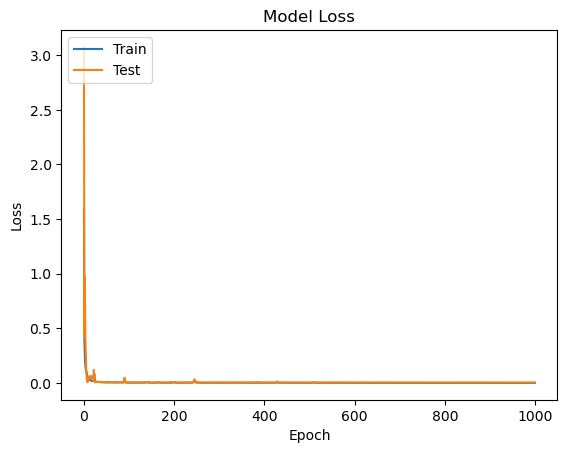

In [16]:
# Plot the loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

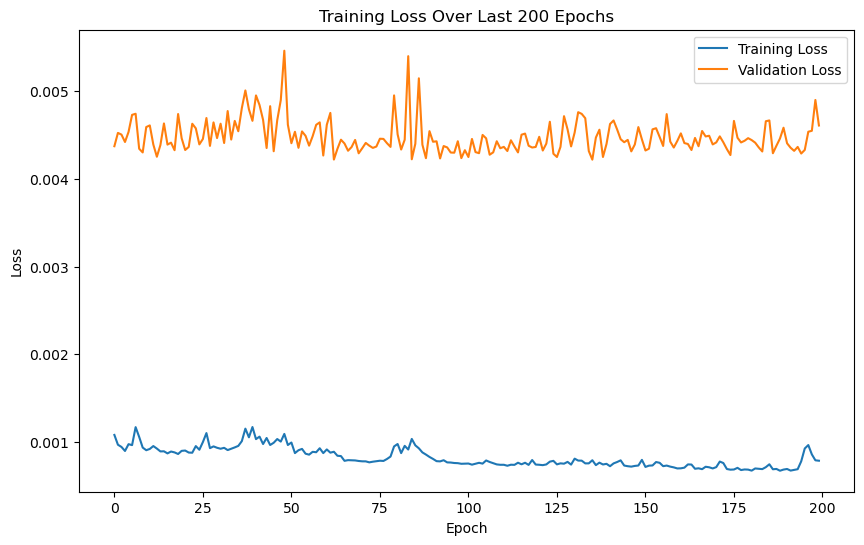

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'][-200:], label='Training Loss')
plt.plot(history.history['val_loss'][-200:], label='Validation Loss')
plt.title('Training Loss Over Last 200 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(27, 32, 1)
(27, 32, 1)


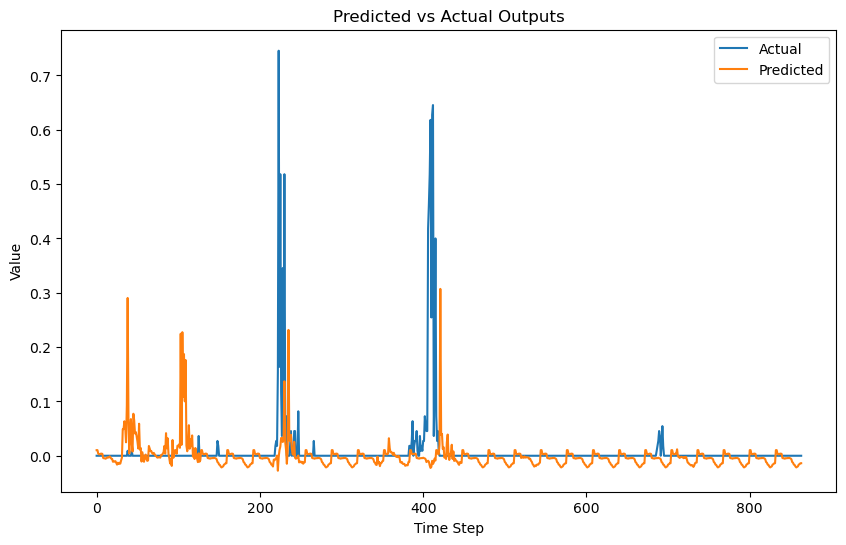

In [18]:
# Make predictions on the test set
predictions = model.predict(test_set)

# Extract the actual values from the test set
actuals = np.concatenate([y for x, y in test_set], axis=0)


print(predictions.shape)
print(actuals.shape)

# Flatten the predictions and actuals
predictions = predictions.flatten()
actuals = actuals.flatten()

# # Inverse transform the predictions and actuals
# predictions = scaler.inverse_transform(predictions.reshape(-1, 2)).flatten()
# actuals = scaler.inverse_transform(actuals.reshape(-1, 2)).flatten()

# Plot the predicted vs actual outputs
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Predicted vs Actual Outputs')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step


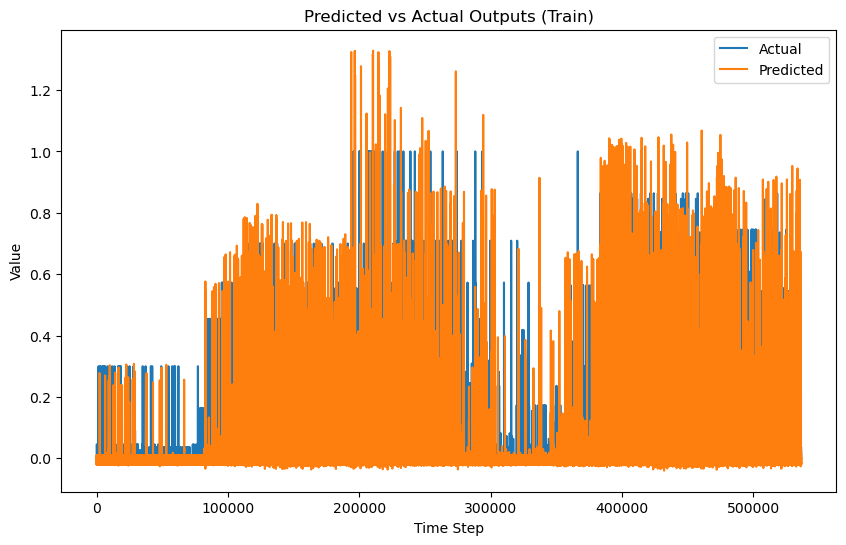

In [19]:
y_pred_train = model.predict(train_set)
y_train = np.concatenate([y for x, y in train_set], axis=0)

y_pred_train = y_pred_train.flatten()
y_train = y_train.flatten()

plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(y_pred_train, label='Predicted')
plt.title('Predicted vs Actual Outputs (Train)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [20]:
model.save_weights('corrector-ae.weights.h5')

In [24]:
# Load the 'beirut-daily-precipitation.csv' file
beirut_df = pd.read_csv('data/beirut-hourly-precipitation.csv')

# Create a windowed dataset from df['value'] without shuffling
beirut_values = beirut_df['value'].values
beirut_values = scaler.transform(beirut_values.reshape(-1, 1)).flatten()
beirut_dataset = windowed_dataset_single(beirut_values, window_size, batch_size)

# Pass the windowed dataset to the model for inference
predictions = model.predict(beirut_dataset)

# Unwrap the windows
corrected_values = predictions.flatten()

# Inverse transform the corrected values
corrected_values = scaler.inverse_transform(corrected_values.reshape(-1, 1)).flatten()

# corrected_values = scaler.inverse_transform(corrected_values.reshape(-1, 2)).flatten()
print(len(corrected_values))
print(len(beirut_df))

# Save the outputs to 'beirut-daily-corrected.csv'
beirut_df = beirut_df[:len(corrected_values)]
beirut_df['value'] = corrected_values
beirut_df.to_csv('data/beirut-hourly-corrected.csv', index=False)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step
221024
221039


/home/edargham/anaconda3/envs/thesis/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [22]:
# Save scaler to disk
import joblib
joblib.dump(scaler, 'corrector-ae.scaler.joblib')

['corrector-ae.scaler.joblib']